# Convolutional neural net with pytorch (and pytorch lightning ⚡)

![](cnn.png)

* Today we will code a convolutional neural networks (CNNs), a type of neural network which is specifically well suited for dealing with images. In the previous tutorial we have seen that multilayer perceptrons present strong limitations when dealing with high dimensional inputs and in this tutorial we will see how CNNs are able to overcome these limitations

* We will be training a CNN on the FashionMNIST dataset

* We will use pytorch and pytorch-lightning and show some tools, such as the tensorboard

기본 CNN 모델을 활용한 FashionMnist 분류기

In [1]:
!pip install pytorch-lightning==1.2.2


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install matplotlib==3.7.3


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install scipy==1.9.3


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

In [5]:
# 버전 확인 용도
import pytorch_lightning as pl
print(torch.__version__)
print(torchvision.__version__)
print(pl.__version__)

2.4.1
0.19.1
1.2.2


## Load the data and visualize it
기존 데이터 셋을 다양한 방법으로 증강을 진행하였습니다. <br>

### 데이터 증강 방법
1. 이미지를 10도 이내 랜덤하게 회전 <br>
2. 이미지를 좌우로 랜덤하게 뒤집기. <br>
3. 이미지에 패딩을 추가하여 확장한 후, 28x28 크기로 랜덤하게 잘라내기 <br>
 -> 해당 방식은 위치 변화에도 경건하게 만들기 위함입니다. <br>
4. 30%의 확률로 이미지의 일부 영역을 랜덤하게 지워주기 <br>
 -> 해당 방식은 일부 픽셀을 가리면서 노이즈나 불완전한 데이터에 잘 대응하도록 만들었습니다. <br>

### Dataset Concat
원본 데이터와 증강 데이터를 결합하며, 두 데이터를 동시에 활용하면서 일반화 성능을 높이도록 합니다. <br>

In [6]:
# 데이터 증강을 위한 변환 정의
data_augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(28, padding=4), # RandomCrop (padding = 4)
    transforms.ToTensor(),  
    transforms.RandomErasing(p=0.3), # 30% Random Erasing
])

# 기본 변환 (정규화만 적용)
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# 원본 데이터셋 (기본 변환 적용)
original_dataset = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=basic_transforms
)

# 증강된 데이터셋 (데이터 증강 적용)
augmented_dataset = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=True,
    download=True,
    transform=data_augmentation_transforms
)

# 데이터셋 결합
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# 검증 데이터셋 로드
fmnist_valid = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',
    train=False,
    download=True,
    transform=basic_transforms
)

# 데이터셋 결합
from torch.utils.data import ConcatDataset

combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

print(f"Original dataset size: {len(original_dataset)}")
print(f"Augmented dataset size: {len(augmented_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Original dataset size: 60000
Augmented dataset size: 60000
Combined dataset size: 120000


In [7]:
num_workers = 16

fmnist_train_loader = DataLoader(combined_dataset, batch_size=128, shuffle=True, num_workers=num_workers) # batch size을 늘려 조금 더 빠르게 학습하도록 합니다.
fmnist_valid_loader = DataLoader(fmnist_valid, batch_size=512, num_workers=num_workers)

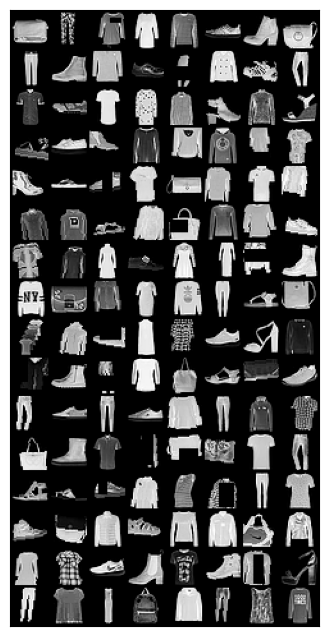

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()

fmnist_train_iter = iter(fmnist_train_loader)
images, labels = next(fmnist_train_iter)
show_images(torchvision.utils.make_grid(images))

In [9]:
class_mapping = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

np.set_printoptions(linewidth=120)
np.array([class_mapping[labels[j].item()] for j in range(64)]).reshape(8, 8)

array([['Bag', 'Trouser', 'Pullover', 'Dress', 'Pullover', 'Sneaker', 'Ankle Boot', 'Bag'],
       ['Trouser', 'Ankle Boot', 'Shirt', 'Sneaker', 'Trouser', 'Coat', 'Sandal', 'Trouser'],
       ['Shirt', 'Sneaker', 'T-shirt/Top', 'Dress', 'Shirt', 'Sandal', 'Shirt', 'Sandal'],
       ['Sandal', 'Sneaker', 'Ankle Boot', 'Shirt', 'Pullover', 'Pullover', 'Dress', 'T-shirt/Top'],
       ['Ankle Boot', 'Sandal', 'Sneaker', 'T-shirt/Top', 'Bag', 'Pullover', 'T-shirt/Top', 'Coat'],
       ['Shirt', 'Pullover', 'Sandal', 'Pullover', 'Bag', 'Pullover', 'Pullover', 'Sneaker'],
       ['Shirt', 'Pullover', 'Dress', 'Sneaker', 'Dress', 'Dress', 'Coat', 'Ankle Boot'],
       ['Pullover', 'Bag', 'Shirt', 'Dress', 'Pullover', 'Trouser', 'Sandal', 'Bag']], dtype='<U11')

## A CNN architecture using pytorch-lightning

Since we will use pytorch-lightning, our class needs to inherit from pl.LightningModule <br>

### Kernel_size & padding
과제 내용에서 제기하듯, BatchNormalization을 제거하였습니다. <br>
추가로 커널 크기 및 패딩을 조절하였습니다. (kernel_size =5, padding = 2) <br>
kernel size을 늘리면서 좀 더 넓은 영역에서 특징을 추출할 수 있도록 하였고, <br>
이에 맞춰 padding을 2로 설정하며 출력 크기를 유지하였습니다. <br>

### Residual Block
BatchNormalization을 제거하였을 때 발생할 수 있는 불안정성을 해결하기 위해 Residual Connection을 도입하여 출력에 입력을 직접 더해줍니다. <br>
Residual Block은 학습 중 기울기 소실 문제를 해결하는데도 유리합니다. <br>
back propagation을 진행하면서 입력 경로를 통해 기울기를 직접 전달하여, 기울기 소실 문제를 완화합니다. <br>
추가로 stride을 통해 차원이 맞지 않을 때 1x1 convolution을 사용하는 shortcut connection을 추가하였습니다. <br>

### 추가 개선안
learning rate을 5e-4로 안정적인 학습을 하도록 설정하였습니다. <br>
weight_decay 또한 1e-5로 설정하며, 과적합을 방지하도록 하였습니다. <br>
Dropout은 0.3으로, 과적합 방지하도록 하였습니다. <br>

In [10]:
import pdb
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=5, stride=stride, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=5, padding=2)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        out += self.shortcut(x) if isinstance(self.shortcut, nn.Conv2d) else x
        out = self.relu(out)
        return out

class FashionCNN(pl.LightningModule):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv = nn.Conv2d(1, 64, kernel_size=7, padding=3)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 256, stride=2)
        self.layer4 = ResidualBlock(256, 512, stride=2)
        self.layer5 = ResidualBlock(512, 512, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)  # Reduced dropout rate
        self.fc = nn.Linear(512, 10)
        self.accuracy = pl.metrics.Accuracy()

    def forward(self, x):
        x = self.relu(self.conv(x))   # 출력: (배치 크기, 64, 28, 28)
        x = self.layer1(x)            # 출력: (배치 크기, 64, 28, 28)
        x = self.layer2(x)            # 출력: (배치 크기, 128, 14, 14)
        x = self.layer3(x)            # 출력: (배치 크기, 256, 7, 7)
        x = self.layer4(x)            # 출력: (배치 크기, 512, 4, 4)
        x = self.layer5(x)            # 출력: (배치 크기, 512, 2, 2)
        x = self.avgpool(x)           # 출력: (배치 크기, 512, 1, 1)
        x = torch.flatten(x, 1)       # 출력: (배치 크기, 512)
        x = self.dropout(x)
        x = self.fc(x)                # 최종 출력: (배치 크기, 10)
        return x

    def _step(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self._step(batch, batch_idx, 'valid')

    def configure_optimizers(self):
        # Adjusted optimizer with lower learning rate
        return torch.optim.Adam(self.parameters(), lr=5e-4, weight_decay=1e-5)

**Pro tip.** When coding and debugging your architecture, don't use print statements to check the sizes of input / output tensors for instance. Use pdb (python debbuger) by writing the line
```python
import pdb; pdb.set_trace()
```
at the place where you want to check stuff

In [11]:
net = FashionCNN()
x = torch.randn(3, 1, 28, 28) # 28x28의 무작위 텐서 3개 생성
out = net(x) # 네트워크에 통과 후 출력 확인
out.size()

torch.Size([3, 10])

In [12]:
print(out)

tensor([[-0.0388,  0.0333, -0.0433,  0.0273,  0.0356, -0.0136,  0.0367, -0.0336,
         -0.0321,  0.0101],
        [-0.0234,  0.0392, -0.0430,  0.0317,  0.0283, -0.0140,  0.0546, -0.0404,
         -0.0429,  0.0043],
        [-0.0244,  0.0415, -0.0217, -0.0037,  0.0212, -0.0179,  0.0349, -0.0539,
         -0.0309,  0.0007]], grad_fn=<AddmmBackward0>)


In [13]:
print(net)

FashionCNN(
  (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu): ReLU(inplace=True)
  (layer1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (shortcut): Sequential()
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (shortcut): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  )
  (layer3): ResidualBlock(
    (conv1): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (shortcut): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  )
  (layer4): ResidualBlock(
    (conv1): Conv2d(256, 5

**Pro tip.** Pytorch lighting proposes many very convenient flags to try and debug before testing. For instance, `fast_dev_run` runs some training and validation steps in order to check that everyting works.

In [14]:
# Initialize a trainer
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=20, fast_dev_run=True)

# Train the model ⚡
trainer.fit(net, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

   | Name     | Type              | Params
------------------------------------------------
0  | conv     | Conv2d            | 3.2 K 
1  | relu     | ReLU              | 0     
2  | layer1   | ResidualBlock     | 204 K 
3  | layer2   | ResidualBlock     | 622 K 
4  | layer3   | ResidualBlock     | 2.5 M 
5  | layer4   | ResidualBlock     | 10.0 M
6  | layer5   | ResidualBlock     | 13.4 M
7  | avgpool  | AdaptiveAvgPool2d | 0     
8  | dropout  | Dropout           | 0     
9  | fc       | Linear            | 5.1 K 
10 | accuracy | Accuracy          | 0     
------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.645   Total estimated model params size (MB)


Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.35s/it]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.98s/it, loss=2.3, train_acc_step=0.109, train_acc_epoch=0.109, valid_acc_step=0.0898, valid_acc_epoch=0.0898]


1

## Display the tensorboard in colab before training

%load_ext tensorboard
%tensorboard --logdir lightning_logs/ --host 0.0.0.0 --port 6014

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## Train for some epochs
Earlystopping 콜백을 도입하여, 5 epoch동안 validation이 개선되지 않으면 중단합니다. <br>
학습 epoch는 150으로 하였습니다. <br>

In [15]:
from pytorch_lightning.callbacks import EarlyStopping

# EarlyStopping 콜백을 설정 (validation_loss가 5번의 에포크 동안 개선되지 않으면 중단)
early_stop_callback = EarlyStopping(
    monitor='valid_loss_epoch',
    patience=5,  # 5번의 에포크 동안 개선되지 않으면 중단
    verbose=True,
    mode='min'  # 손실이 최소화될 때 중단
)

trainer = pl.Trainer(gpus=1, max_epochs=150, progress_bar_refresh_rate=20)
trainer.fit(net, train_dataloader=fmnist_train_loader, val_dataloaders=fmnist_valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

   | Name     | Type              | Params
------------------------------------------------
0  | conv     | Conv2d            | 3.2 K 
1  | relu     | ReLU              | 0     
2  | layer1   | ResidualBlock     | 204 K 
3  | layer2   | ResidualBlock     | 622 K 
4  | layer3   | ResidualBlock     | 2.5 M 
5  | layer4   | ResidualBlock     | 10.0 M
6  | layer5   | ResidualBlock     | 13.4 M
7  | avgpool  | AdaptiveAvgPool2d | 0     
8  | dropout  | Dropout           | 0     
9  | fc       | Linear            | 5.1 K 
10 | accuracy | Accuracy          | 0     
------------------------------------------------
26.7 M    Trainable params
0         Non-trainable params
26.7 M    Total params
106.645   Total estimated model params size (MB)


Epoch 0:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 940/958 [00:56<00:01, 16.52it/s, loss=0.49, v_num=1, valid_acc_epoch=0.0938, train_acc_step=0.750]
Validating: 0it [00:00, ?it/s]
Epoch 1:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 940/958 [00:57<00:01, 16.38it/s, loss=0.379, v_num=1, valid_acc_epoch=0.855, train_acc_step=0.789, train_acc_epoch=0.727, valid_acc_step=0.875]
Validating: 0it [00:00, ?it/s]
Epoch 2:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 940/958 [00:57<00:01, 16.44it/s, loss=0.322, v_num=1, valid_acc_epoch=0.881, train_acc_step=0.898, train_acc_epoch=0.845, valid_acc_step=0.879]
Validating: 0it [00:00, ?it/s]
Epoch 3:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████  | 940

1

### 학습과정 시각화
기록한 log을 matplotlib을 이용하여서도 시각화하였습니다.

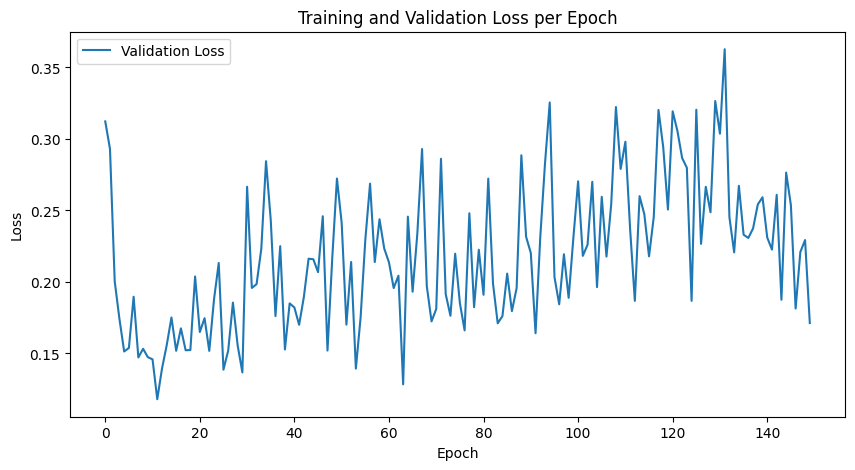

In [16]:
import matplotlib.pyplot as plt

# logged_metrics에서 validation loss을 리스트로 추출
val_losses = []

# trainer.logged_metrics의 값을 직접 추출
for epoch in range(200):
    val_loss_key = f'valid_loss_step/epoch_{epoch}'

    # 손실 및 정확도 값을 기록
    if val_loss_key in trainer.logged_metrics:
        val_losses.append(trainer.logged_metrics[val_loss_key].cpu().item())

# Train & Validation Loss 플롯
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Check some validation metrics

In [17]:
def get_predictions(model, loader):
    all_preds = torch.tensor([]).detach()
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds.detach()

In [18]:
# Note: we should increase the batch_size to compure pure forward predictions
predictions = get_predictions(net, fmnist_valid_loader)
scores = F.softmax(predictions, dim=1)

In [19]:
scores[:3].detach()

tensor([[4.9519e-17, 3.9267e-14, 1.7274e-18, 3.8690e-14, 1.0741e-17, 1.7916e-09,
         1.4835e-16, 3.0688e-09, 5.0253e-13, 1.0000e+00],
        [2.7838e-07, 6.4445e-14, 1.0000e+00, 9.4927e-12, 1.1291e-07, 4.6236e-16,
         1.9660e-07, 1.5156e-19, 1.7804e-13, 2.7910e-18],
        [5.6440e-24, 1.0000e+00, 4.6608e-24, 2.0161e-20, 2.0115e-27, 5.2385e-26,
         1.7773e-24, 9.3104e-30, 2.1020e-26, 3.1360e-25]])

In [20]:
!pip install scikit-plot


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

cm = confusion_matrix(fmnist_valid.targets, scores.argmax(dim=1))
cm

array([[890,   0,  15,  13,   0,   0,  78,   0,   4,   0],
       [  1, 990,   1,   6,   0,   0,   1,   0,   1,   0],
       [ 17,   0, 932,   8,  16,   0,  27,   0,   0,   0],
       [ 14,   4,  14, 942,   7,   0,  19,   0,   0,   0],
       [  1,   0,  35,  23, 910,   0,  31,   0,   0,   0],
       [  0,   0,   0,   0,   0, 987,   0,   8,   0,   5],
       [ 79,   2,  37,  18,  41,   0, 821,   0,   2,   0],
       [  0,   0,   0,   0,   0,   1,   0, 985,   0,  14],
       [  2,   0,   4,   0,   1,   1,   1,   0, 991,   0],
       [  0,   0,   1,   0,   0,   5,   0,  22,   0, 972]], dtype=int64)

<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

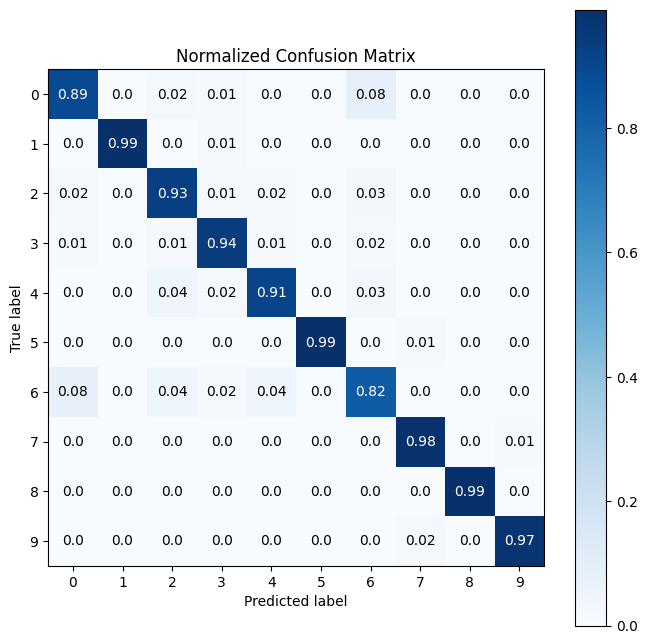

In [22]:
skplt.metrics.plot_confusion_matrix(fmnist_valid.targets, scores.argmax(dim=1), normalize=True, figsize=(8, 8))

## Task

아래의 과제들을 수행해보기
- Look for a better architecture (for instance, change padding and kernel sizes, have a look at https://github.com/zalandoresearch/fashion-mnist), try different solvers / learning rates
- Remove batch normalization, change dropout parameters, try residual connections
- Add data augmentation in the transformations used in the DataLoaders (have a look at https://github.com/zalandoresearch/fashion-mnist)
- It's possible to reach > 94% accuracy, once again have a look at https://github.com/zalandoresearch/fashion-mnist

## 결론
학습 모델의 일반화를 위해, 학습 데이터를 다양한 방식으로 증강하였습니다. <br>
또한 증강한 데이터와 기존 데이터를 합쳐 데이터 수는 2배로 만들었으며 조금 더 일반화된 성능을 내도록 하였습니다. <br>

batch normalization을 제거하였을 경우, 처음 높은 성능이 나오지 못하였습니다. <br>
이는 입력 데이터가 정규화되지 못하며, 네트워크가 입력값의 분포 변화에 더 민감해진 것을 확인했습니다. <br>
해당 문제를 해결하기 위해 residual connection을 추가하여 기울기 소실 문제를 완화하며 학습이 원활하게 진행되도록 하였습니다. <br>
residual connection에서 입력과 출력을 맞춰주기 위해 1x1 convolution을 가진 shortcut connection을 추가하였습니다. <br>

학습한 후 validation 결과가 처음에는 잘 내려가다 요동치는 것을 보아, batch normalization을 하지 않았을 때 학습이 불안정하다는 것을 확인할 수 있었습니다. <br>
결국 loss는 잘 떨어지는 것을 확인하였으며, 학습이 어느정도 잘 된 것을 확인하였습니다. <br>

또한 kernel size와 padding을 늘리면서 학습할 때 전역적인 특징을 더 잘 학습할 수 있게 하면서 크기는 유지합니다. <br>
조금 더 학습을 잘할 수 있도록 layer를 추가하여 복잡도를 증가시켰습니다. <br>
마지막에는 adaptive average pooling을 추가하여 fully connected layer에 전달할 글로벌 특징을 추출하도록 만듭니다. <br>

해당 기법들과 layer를 통해 학습을 진행함으로써, 이 모델은 94.1%의 정확도를 내는 것을 확인할 수 있었습니다. <br>